# Atlas notebooks

***

> This notebook reproduces and extends parts of the figures and products of the AR6-WGI Atlas. It is part of a notebook collection available at https://github.com/IPCC-WG1/Atlas for reproducibility and reusability purposes. This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0).
>
> ![Creative Commons License >](https://i.creativecommons.org/l/by/4.0/88x31.png)

## Remote loading and model ensembles building of climate projection data in climate4R.

08/07/2021

**M. Iturbide** (Santander Meteorology Group. Institute of Physics of Cantabria, CSIC-UC, Santander, Spain).

This notebook describes the generation of two NetCDF data files that are included as [auxiliary material](./auxiliary-material) in this repository (`CMIP5_historical_pr.nc` and `CMIP5_rcp85_pr.nc`). These files contain precipitation climatologies of a reduced set of CMIP5 models for the 1986-2005 and 2041-2060 periods, respectively.

### Load libraries and functions

We will use the following climate4R libraries:
 * `loadeR` and `loadeR.2nc` to load and save data ([Iturbide et al., 2018](https://doi.org/10.1016/j.envsoft.2018.09.009))
 * `visualizeR` for data visualization ([Frías et al., 2018](https://doi.org/10.1016/j.envsoft.2017.09.008))
 
We will also need:
 * `devtools` to source remote R code (`source_url` function)

In [ ]:
library(loadeR)
library(loadeR.2nc)
library(visualizeR)
library(devtools)

In this notebook, the `climate4R.chunk` function is used to perform climate data loading and temporal aggregation in the same step and by latitudinal chunks. This has the great advantage of avoiding the creation of heavy objects and making requests for small pieces of data in each iteration. This results in more efficient data loading and management. To load the function in the working environment use the `source_url` function as follows.

In [2]:
source_url("https://github.com/SantanderMetGroup/climate4R/blob/v1.5.1/R/climate4R.chunk.R?raw=TRUE")

ℹ SHA-1 hash of file is feed646847e95e5c030a0949248ddfd5001a1ae4



### Parameter settings

Set custom parameters to be used below in this notebook. Enter here the variable, CMIP era, scenario and temporal and spatial scope of the analysis.

In [3]:
var <- "pr"
project <- "CMIP5"
scenario <- "rcp85"
season <- c(12, 1, 2)
base.period <- 1986:2005
future.period <- 2041:2060
# Target region boundaries
lonLim <- c(-10, 35)
latLim <- c(35, 75)

The season is a sequence of month numbers. Use `1:12` for the entire year. Boreal winter (DJF) is `season = c(12, 1, 2)` and so on.

Select also the number of chunks. Chunking sequentially splits the task into manageable data chunks to avoid memory problems. Chunking operates by spliting the data into a predefined number latitudinal slices (2, in this example). See the documentation of [climate4R.chunk](https://github.com/SantanderMetGroup/climate4R/tree/master/R) for further details.

In [4]:
n.chunks <- 2

### Extract and select the ensemble models



The function `UDG.datasets` returns the list of available datasets matching a pattern. Here the selected project and scenario is used as the search pattern (historical data is also listed).

In [5]:
dataset.hist <- UDG.datasets(paste0(project, ".*historical"))
dataset.scen <- UDG.datasets(paste0(project, ".*", scenario))

Matches found for: CMIP5_AR5_1run CMIP5_AR5 CMIP5_subset

Label names are returned, set argument full.info = TRUE to get more information

Matches found for: CMIP5_AR5_1run CMIP5_AR5 CMIP5_subset

Label names are returned, set argument full.info = TRUE to get more information



We select the set of models CMIP5_AR5_1run

In [6]:
dataset.hist <- dataset.hist[["CMIP5_AR5_1run"]]
dataset.scen <- dataset.scen[["CMIP5_AR5_1run"]]

Check the available models:

In [7]:
dataset.scen

[1] "CMIP5_ACCESS1-0_r1i1p1_rcp85"      "CMIP5_ACCESS1-3_r1i1p1_rcp85"     
 [3] "CMIP5_bcc-csm1-1-m_r1i1p1_rcp85"   "CMIP5_bcc-csm1-1_r1i1p1_rcp85"    
 [5] "CMIP5_BNU-ESM_r1i1p1_rcp85"        "CMIP5_CanESM2_r1i1p1_rcp85"       
 [7] "CMIP5_CCSM4_r1i1p1_rcp85"          "CMIP5_CESM1-BGC_r1i1p1_rcp85"     
 [9] "CMIP5_CMCC-CESM_r1i1p1_rcp85"      "CMIP5_CMCC-CM_r1i1p1_rcp85"       
[11] "CMIP5_CMCC-CMS_r1i1p1_rcp85"       "CMIP5_CNRM-CM5_r1i1p1_rcp85"      
[13] "CMIP5_CSIRO-Mk3-6-0_r1i1p1_rcp85"  "CMIP5_EC-EARTH_r1i1p1_rcp85"      
[15] "CMIP5_FGOALS-g2_r1i1p1_rcp85"      "CMIP5_GFDL-CM3_r1i1p1_rcp85"      
[17] "CMIP5_GFDL-ESM2G_r1i1p1_rcp85"     "CMIP5_GFDL-ESM2M_r1i1p1_rcp85"    
[19] "CMIP5_HadGEM2-CC_r1i1p1_rcp85"     "CMIP5_HadGEM2-ES_r1i1p1_rcp85"    
[21] "CMIP5_inmcm4_r1i1p1_rcp85"         "CMIP5_IPSL-CM5A-LR_r1i1p1_rcp85"  
[23] "CMIP5_IPSL-CM5A-MR_r1i1p1_rcp85"   "CMIP5_IPSL-CM5B-LR_r1i1p1_rcp85"  
[25] "CMIP5_MIROC-ESM-CHEM_r1i1p1_rcp85" "CMIP5_MIROC-ESM_r1i1p1_rcp85"     
[27] "CMIP5_MIROC5_r1i1p1_rcp85"         "CMIP5_MPI-ESM-LR_r1i1p1_rcp85"    
[29] "CMIP5_MPI-ESM-MR_r1i1p1_rcp85"     "CMIP5_MRI-CGCM3_r1i1p1_rcp85"     
[31] "CMIP5_NorESM1-M_r1i1p1_rcp85"

For brevity, we will only use the first 6 models. 

To ensure that we get the same ensemble of models for both the historical and the future scenario we define the model names as follows:

In [8]:
n.models <- 6
models <- gsub(paste0("_", scenario), "", dataset.scen[1:n.models])
models

[1] "CMIP5_ACCESS1-0_r1i1p1"    "CMIP5_ACCESS1-3_r1i1p1"   
[3] "CMIP5_bcc-csm1-1-m_r1i1p1" "CMIP5_bcc-csm1-1_r1i1p1"  
[5] "CMIP5_BNU-ESM_r1i1p1"      "CMIP5_CanESM2_r1i1p1"

Search the position of each model in `dataset.hist` and `dataset.ssp` using `grep` in a loop. Subsequently, use these positions to subset the corresponding datasets.

In [9]:
find.index <- function(target, all) vapply(target, grep, numeric(length = 1), x = all)
dataset.hist <- dataset.hist[find.index(models, dataset.hist)]
dataset.scen <- dataset.scen[find.index(models, dataset.scen)]
dataset.hist; dataset.scen

[1] "CMIP5_ACCESS1-0_r1i1p1_historical"   
[2] "CMIP5_ACCESS1-3_r1i1p1_historical"   
[3] "CMIP5_bcc-csm1-1-m_r1i1p1_historical"
[4] "CMIP5_bcc-csm1-1_r1i1p1_historical"  
[5] "CMIP5_BNU-ESM_r1i1p1_historical"     
[6] "CMIP5_CanESM2_r1i1p1_historical"

[1] "CMIP5_ACCESS1-0_r1i1p1_rcp85"    "CMIP5_ACCESS1-3_r1i1p1_rcp85"   
[3] "CMIP5_bcc-csm1-1-m_r1i1p1_rcp85" "CMIP5_bcc-csm1-1_r1i1p1_rcp85"  
[5] "CMIP5_BNU-ESM_r1i1p1_rcp85"      "CMIP5_CanESM2_r1i1p1_rcp85"

Now we are sure that the same models (in the same order) are selected for both scenarios.

### Load data

The original function for data loading is `loadGridData`. However, if `climate4R.chunk` is used, data loading is performed internally together with an additional `climate4R` function (`climatology` in this example). For more details of the use of `climate4R.chunk`, check the [documentation](https://github.com/SantanderMetGroup/climate4R/tree/master/R).

`climate4R.chunk` is applied in a `lapply` loop to perform the same operation on each model. This data loading takes above 30 minutes.

In [10]:
load.dataset <- function(dataset, period){
    lapply(dataset, function(i) 
        climate4R.chunk(n.chunks = n.chunks,
            C4R.FUN.args = list(
                FUN = "climatology",
                grid = list(dataset = i, var = var)
            ),
            loadGridData.args = list(
                years = period,
                season = season,
                lonLim = lonLim,
                latLim = latLim
            )
        )
    )
}

In [ ]:
hist <- load.dataset(dataset.hist, base.period)
scen <- load.dataset(dataset.scen, future.period)

### Build the ensemble 
Interpolate (function `interpGrid`) to the common grid available in this repository and build the ensemble (function `bindGrid`):

In [12]:
common.grid <- loadGridData("../reference-grids/land_sea_mask_2degree.nc4", var = "sftlf", lonLim = lonLim, latLim = latLim)
interpolate <- function(grid) lapply(grid, function(i) interpGrid(i, getGrid(common.grid), method = "bilinear"))
hist.ens <- bindGrid(interpolate(hist), dimension = "member", dataset.attr = sprintf("%s historical model subset", project))
scen.ens <- bindGrid(interpolate(scen), dimension = "member", dataset.attr = sprintf("%s %s model subset", project, scenario))

[2021-07-22 17:36:18] Defining geo-location parameters

[2021-07-22 17:36:18] Defining time selection parameters

NOTE: Undefined Dataset Time Axis (static variable)

[2021-07-22 17:36:18] Retrieving data subset ...

[2021-07-22 17:36:18] Done

[2021-07-22 17:36:18] Performing bilinear interpolation... may take a while

[2021-07-22 17:36:18] Done

[2021-07-22 17:36:18] Performing bilinear interpolation... may take a while

[2021-07-22 17:36:18] Done

[2021-07-22 17:36:18] Performing bilinear interpolation... may take a while

[2021-07-22 17:36:18] Done

[2021-07-22 17:36:18] Performing bilinear interpolation... may take a while

[2021-07-22 17:36:18] Done

[2021-07-22 17:36:18] Performing bilinear interpolation... may take a while

[2021-07-22 17:36:18] Done

[2021-07-22 17:36:18] Performing bilinear interpolation... may take a while

[2021-07-22 17:36:18] Done

The input grid is a climatology: temporal resolution set to 'unknown'

The input grid is a climatology: temporal resolution s

The output is a climate4R grid of the precipitation climatology that includes the `member` dimension (i.e. a multi-member grid):

In [13]:
str(scen.ens)

List of 6
 $ Variable           :List of 2
  ..$ varName: chr "pr"
  ..$ level  : NULL
  ..- attr(*, "use_dictionary")= logi TRUE
  ..- attr(*, "description")= chr "Precipitation"
  ..- attr(*, "units")= chr "mm"
  ..- attr(*, "longname")= chr "total precipitation amount"
  ..- attr(*, "daily_agg_cellfun")= chr "none"
  ..- attr(*, "monthly_agg_cellfun")= chr "none"
  ..- attr(*, "verification_time")= chr "none"
 $ Data               : num [1:6, 1, 1:21, 1:23] 1.552 1.15 NA 0.977 0.901 ...
  ..- attr(*, "dimensions")= chr [1:4] "member" "time" "lat" "lon"
 $ xyCoords           :List of 2
  ..$ x: num [1:23] -9 -7 -5 -3 -1 1 3 5 7 9 ...
  ..$ y: num [1:21] 35 37 39 41 43 45 47 49 51 53 ...
  ..- attr(*, "resX")= num 2
  ..- attr(*, "resY")= num 2
  ..- attr(*, "projection")= chr "LatLonProjection"
  ..- attr(*, "interpolation")= chr "bilinear"
 $ Dates              :List of 2
  ..$ start: chr "2040-12-01 12:00:00 GMT"
  ..$ end  : chr "2060-02-29 12:00:00 GMT"
  ..- attr(*, "season")= i

We can display the result using `spatialPlot`:

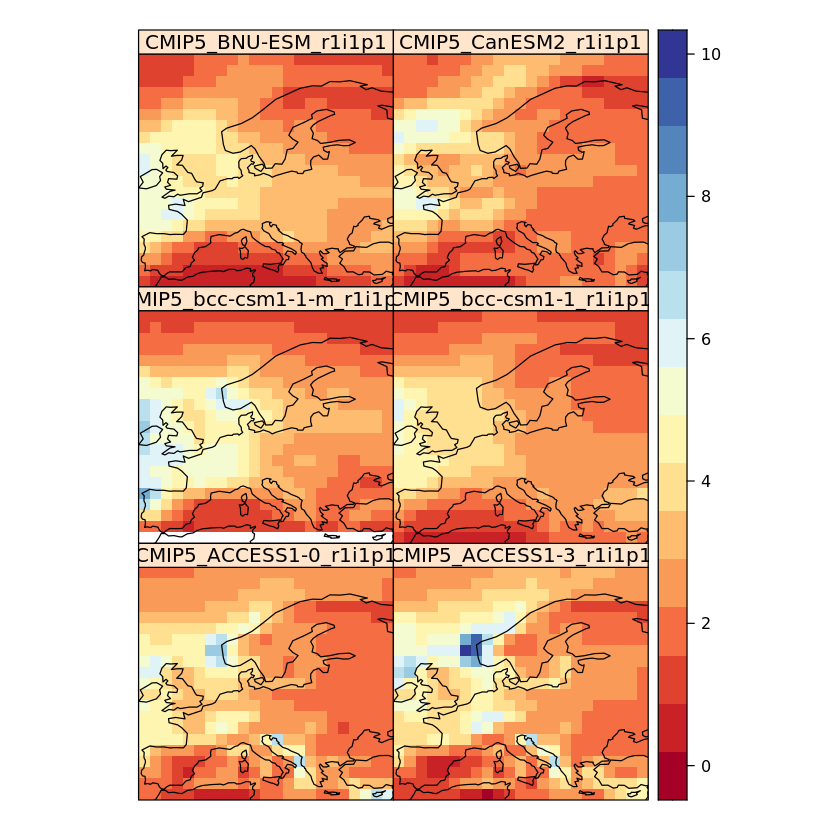

In [15]:
spatialPlot(scen.ens, backdrop.theme = "coastline", names.attr = models)

### Export to NetCDF

Finally, we can export these objects to NetCDF files for later use (see e.g. the [hatching-uncertainty](./hatching-uncertainty_R.ipynb) notebook).

In [17]:
grid2nc(hist.ens, sprintf("auxiliary-material/%s_historical_%s.nc", project, var))
grid2nc(scen.ens, sprintf("auxiliary-material/%s_%s_%s.nc", project, scenario, var))

[2021-07-22 17:41:23] NetCDF file written in: auxiliary-material/CMIP5_historical_pr.nc

[2021-07-22 17:41:23] NetCDF file written in: auxiliary-material/CMIP5_rcp85_pr.nc



### Session Information

In [18]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /srv/conda/envs/notebook/lib/libopenblasp-r0.3.15.so

locale:
 [1] LC_CTYPE=en_US.UTF-8          LC_NUMERIC=C                 
 [3] LC_TIME=en_US.UTF-8           LC_COLLATE=en_US.UTF-8       
 [5] LC_MONETARY=en_US.UTF-8       LC_MESSAGES=en_US.UTF-8      
 [7] LC_PAPER=en_US.UTF-8          LC_NAME=en_US.UTF-8          
 [9] LC_ADDRESS=en_US.UTF-8        LC_TELEPHONE=en_US.UTF-8     
[11] LC_MEASUREMENT=en_US.UTF-8    LC_IDENTIFICATION=en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] devtools_2.4.1      usethis_2.0.1       visualizeR_1.6.1   
[4] transformeR_2.1.2   loadeR.2nc_0.1.2    loadeR_1.7.1       
[7] climate4R.UDG_0.2.3 loadeR.java_1.1.1   rJava_1.0-4        

loaded via a namespace (and not attached):
 [1] CircStats_0.2-6         bitops_1.0-7  